In [12]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F 

In [13]:
def default_conv(in_channels, out_channels, kernel_size, stride=1, padding=None, bias=True, groups=1):
    if not padding and stride == 1:
        padding = kernel_size // 2
    return nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, 
                     padding=padding, bias=bias, groups=groups)

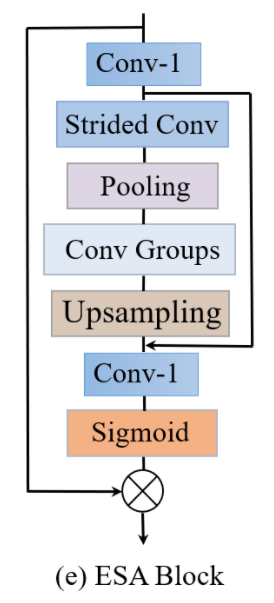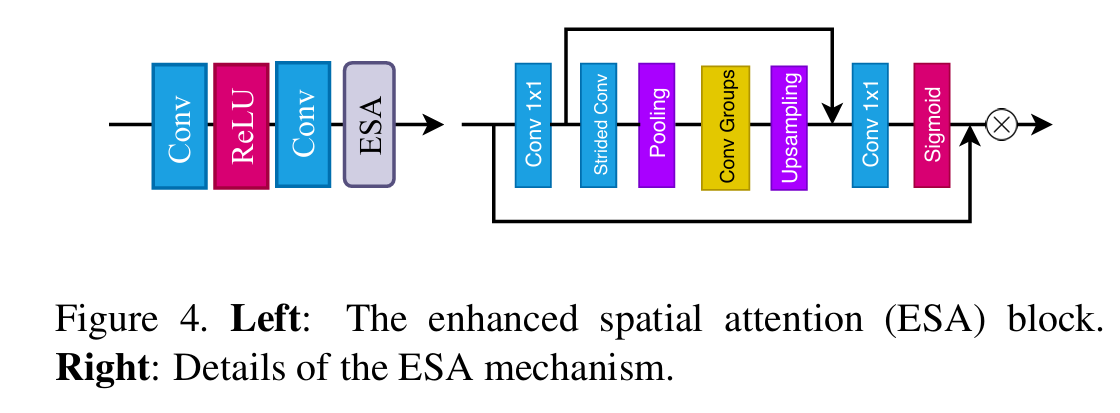

In [14]:
class ESA(nn.Module):
    """
    ESA: Enhanced spatial attention 增强空间注意力
    from Residual Feature Aggregation Network for Image Super-Resolution
         CVPR 2020
    """
    def __init__(self, n_feats, conv=default_conv) -> None:
        super().__init__()
        f = n_feats // 4
        # conv 1X1
        self.conv1 = conv(n_feats, f, kernel_size=1)
        self.conv_f = conv(f, f, kernel_size=1)
        self.conv_max = conv(f, f, kernel_size=3, padding=1)
        # stride conv
        self.conv2 = conv(f, f, kernel_size=3, stride=2, padding=0)
        self.conv3 = conv(f, f, kernel_size=3, padding=1)
        self.conv3_ = conv(f, f, kernel_size=3, padding=1)
        self.conv4 = conv(f, n_feats, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        c1_ = (self.conv1(x))
        c1 = self.conv2(c1_)
        # pooling
        v_max = F.max_pool2d(c1, kernel_size=7, stride=3)
        v_range = self.relu(self.conv_max(v_max))
        c3 = self.relu(self.conv3(v_range))
        c3 = self.conv3_(c3)
        # upsampling
        c3 = F.interpolate(c3, (x.size(2), x.size(3)), mode='bilinear', align_corners=False)
        cf = self.conv_f(c1_)
        c4 = self.conv4(c3 + cf)
        m = self.sigmoid(c4)
        return x * m

In [15]:
conv1 = nn.Conv2d(30, 6, 3, 1, padding=1, groups=2)
x = torch.randn(20, 30, 16, 16)
print(f'conv1_weight : {conv1.weight.size()}')
conv1(x).size()

conv1_weight : torch.Size([6, 15, 3, 3])


torch.Size([20, 6, 16, 16])

In [18]:
class RFDN_ESA(nn.Module):
    """RFDN 增强空间注意力机制 Enhance Spatial Attention ESA"""
    def __init__(self, n_feats, conv):
        """增强空间注意力机制 Enhance Spatial Attention ESA

        Args:
            n_feats : 输入特征通道数
            conv : 卷积, such as nn.Conv2d
        """
        super().__init__()
        f = n_feats // 4
        self.conv1 = conv(n_feats, f, kernel_size=1)
        self.conv_f = conv(f, f, kernel_size=1)
        self.conv_max = conv(f, f, kernel_size=3, padding=1)
        self.conv2 = conv(f, f, kernel_size=3, stride=2, padding=0)
        self.conv3 = conv(f, f, kernel_size=3, padding=1)
        self.conv3_ = conv(f, f, kernel_size=3, padding=1)
        self.conv4 = conv(f, n_feats, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        c1_ = (self.conv1(x))
        print(f'c1_ size : {c1_.size()}')
        c1 = self.conv2(c1_)
        print(f'c1 size : {c1.size()}')
        v_max = F.max_pool2d(c1, kernel_size=7, stride=3)
        print(f'v_max size : {v_max.size()}')
        v_range = self.relu(self.conv_max(v_max))
        c3 = self.relu(self.conv3(v_range))
        c3 = self.conv3_(c3)
        print(f'c3 size : {c3.size()}')
        c3 = F.interpolate(c3, (x.size(2), x.size(3)), mode='bilinear', align_corners=False)
        print(f'upsample c3 size : {c3.size()}')
        cf = self.conv_f(c1_)
        c4 = self.conv4(c3+cf)
        m = self.sigmoid(c4)
        print(f'm size : {m.size()}')

        return x * m

In [20]:
model = RFDN_ESA(16, nn.Conv2d)
x = torch.randn(32, 16, 64, 64)
y = model(x)

c1_ size : torch.Size([32, 4, 64, 64])
c1 size : torch.Size([32, 4, 31, 31])
v_max size : torch.Size([32, 4, 9, 9])
c3 size : torch.Size([32, 4, 9, 9])
upsample c3 size : torch.Size([32, 4, 64, 64])
m size : torch.Size([32, 16, 64, 64])


In [ ]:
class BSRN_ESA(nn.Module):
    def __init__(self, num_feat=50, conv=nn.Conv2d, p=0.25):
        super(ESA, self).__init__()
        f = num_feat // 4
        BSConvS_kwargs = {}
        if conv.__name__ == "BSConvS":
            BSConvS_kwargs = {"p": p}
        self.conv1 = nn.Conv2d(num_feat, f, 1)
        self.conv_f = nn.Conv2d(f, f, 1)
        self.maxPooling = nn.MaxPool2d(kernel_size=7, stride=3)
        self.conv_max = conv(f, f, kernel_size=3, **BSConvS_kwargs)
        self.conv2 = conv(f, f, 3, 2, 0)
        self.conv3 = conv(f, f, kernel_size=3, **BSConvS_kwargs)
        self.conv3_ = conv(f, f, kernel_size=3, **BSConvS_kwargs)
        self.conv4 = nn.Conv2d(f, num_feat, 1)
        self.sigmoid = nn.Sigmoid()
        self.GELU = nn.GELU()

    def forward(self, input):
        c1_ = self.conv1(input)
        c1 = self.conv2(c1_)
        v_max = self.maxPooling(c1)
        v_range = self.GELU(self.conv_max(v_max))
        c3 = self.GELU(self.conv3(v_range))
        c3 = self.conv3_(c3)
        c3 = F.interpolate(
            c3, (input.size(2), input.size(3)), mode="bilinear", align_corners=False
        )
        cf = self.conv_f(c1_)
        c4 = self.conv4((c3 + cf))
        m = self.sigmoid(c4)

        return input * m